<a href="https://colab.research.google.com/github/Pumafi/flumy-wgan-mines/blob/main/conditioning_model_3d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation in 3D of Conditioning Generator to observations

## Imports

In [ ]:
import sys
sys.path.append('..')

In [4]:
from tensorflow import keras
from utils.visualisation import *
from utils.visualisation_conditioning import *
from data.load_data import get_3d_flumy_data, ConditionalDataGenerator3D
from models.load_trained_models import load_mswgen_sn_3d_horizontal
from utils.utils import generate_noise, correct_percentage_3d

from models.conditional_generation.parametric_generation_network_3d import InferenceModel3D, train_inference_network_3d

import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from keras.utils.np_utils import to_categorical

tf.config.run_functions_eagerly(True)

!pip install -U tensorflow-addons
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 38.6 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Load 3D model

In [5]:
slice_size = (16, 64, 128, 4)
noise_shape = (2, 8, 16, 1)

# Creating the 3D Generator Model
g_model = load_mswgen_sn_3d_horizontal("./trainedweights/mswgen3d/cp-gen2d_horizontal_good.ckpt")
g_model.summary()

Model: "multi_scale_generator3d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator_initial (Generato  multiple                 7168      
 rInitial)                                                       
                                                                 
 generator_block (GeneratorB  multiple                 1327876   
 lock)                                                           
                                                                 
 generator_block_1 (Generato  multiple                 332164    
 rBlock)                                                         
                                                                 
 generator_block_2 (Generato  multiple                 83140     
 rBlock)                                                         
                                                                 
 last_generator_block (LastG  multiple     

## Load data and datagenerator

In [17]:
x_generated = get_3d_flumy_data(filename = "./data/3D/dataFlumy3D.csv",
                data_file = './data/3D',
                dataset = "./data/3D/dataFlumy3D.csv",
                max_simulation_nb=30)[:20, :16]
x_generated = to_categorical(x_generated, num_classes=4)
print("Sanity check, size: ", x_generated.shape)

Sanity check, size:  (20, 16, 64, 128, 4)


In [78]:
nb_wells = 5

In [79]:
dataloader = ConditionalDataGenerator3D(x_generated, 1, slice_size, wells=nb_wells, mode=1)
x, msk, y = dataloader.__getitem__(0)
print(x.shape, msk.shape, y.shape)

(1, 16, 64, 128, 4) (1, 16, 64, 128, 1) (1, 16, 64, 128, 4)


In [80]:
x.shape

(1, 16, 64, 128, 4)

In [81]:
cmap, norm = get_color_map(number_of_categories=4)

In [82]:
# Get the coordinates of observation wells
_, z_cond_pxl, x_cond_pxl, y_cond_pxl, _ = np.nonzero(msk)
wells_xy_coordinates = list(set(list(zip(x_cond_pxl, y_cond_pxl))))
wells_xy_coordinates

[(36, 40), (36, 8), (36, 104), (36, 72), (4, 40), (4, 8), (4, 104), (4, 72)]

In [117]:
selected_point_x, selected_point_y = wells_xy_coordinates[0][0], wells_xy_coordinates[0][1]
horizontal_slice = y[:, :, selected_point_x]
vertical_slice = y[:, :, :, selected_point_y]

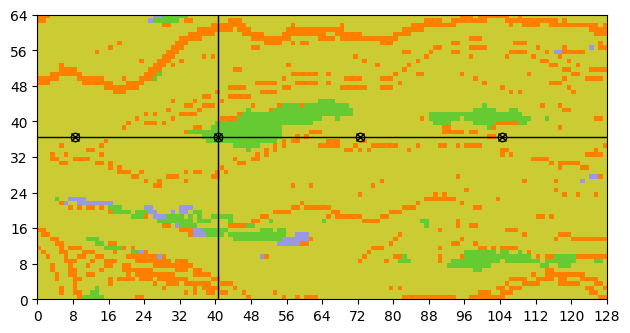

In [146]:
slice_size_wh = (64, 128)
slice_generated_images = y[:, 0]
img_interpolated = np.argmax(slice_generated_images, axis=-1).reshape(slice_size_wh)
plt.axis('on')
plt.xticks(np.arange(0, 129, step=8))
plt.yticks(np.arange(0, 65, step=8))

plt.imshow(img_interpolated, interpolation='nearest', cmap=cmap, norm=norm, origin="lower", extent=(0, slice_size_wh[1], 0, slice_size_wh[0]))
#plt.plot(33.5, 19.5, marker='x', color="black")
for i in range(4):
    plt.plot(wells_xy_coordinates[i][1]+0.5, selected_point_x+0.5, marker='o', color="black", fillstyle='none')
    plt.plot(wells_xy_coordinates[i][1]+0.5, selected_point_x+0.5, marker='x', color="black", fillstyle='none')
plt.plot([0, slice_size_wh[1]], [selected_point_x + 0.5, selected_point_x + 0.5], color="black", linewidth=1)
plt.plot([selected_point_y+0.5, selected_point_y+0.5], [0, slice_size_wh[0]], color="black", linewidth=1)
plt.tight_layout()
plt.show()

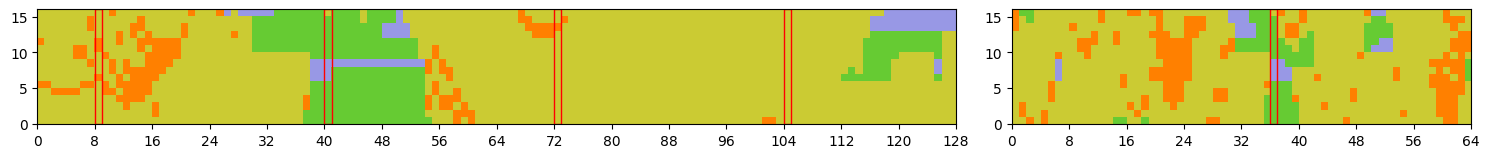

In [142]:
   # plt.figure(figsize=figsize)
from matplotlib.patches import Rectangle


depth = 16
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 2]}, figsize=(15, 15))

#plt.figsize((20, 40))

img_interpolated = np.argmax(horizontal_slice, axis=-1).reshape((depth, slice_size_wh[1]))
a0.axis('on')

a0.imshow(img_interpolated, interpolation='nearest', cmap=cmap, norm=norm, origin="lower", extent=(0, slice_size_wh[1], 0, depth))

plt.setp(a0, xticks=np.arange(0, 129, step=8))

for i in range(4):
    #plt.plot(wells_xy_coordinates[i][1]+0.5, selected_point_x+0.5, marker='o', color="black", fillstyle='none')
    #plt.plot(wells_xy_coordinates[i][1]+0.5, selected_point_x+0.5, marker='x', color="black", fillstyle='none')
    a0.add_patch(Rectangle((wells_xy_coordinates[i][1], 0),1,depth,linewidth=1,edgecolor='r',facecolor='none'))

img_interpolated = np.argmax(vertical_slice, axis=-1).reshape((depth, slice_size_wh[0]))
a1.axis('on')
a1.imshow(img_interpolated, interpolation='nearest', cmap=cmap, norm=norm, origin="lower", extent=(0, slice_size_wh[0], 0, depth))
a1.add_patch(Rectangle((selected_point_x , 0),1,depth,linewidth=1,edgecolor='r',facecolor='none'))
plt.setp(a1, xticks=np.arange(0, 65, step=8))
#a0.set_title('Vertical slice of the Flumy simulation along the y axis', fontdict={'fontsize': 10,})
#a1.set_title('Vertical slice of the Flumy simulation along the x axis', fontdict={'fontsize': 10,})
f.tight_layout()

f.show()

## Training the model

In [86]:
inference_network = InferenceModel3D(noise_shape, nhidden=32, hidden_neurons_nb=8)

In [87]:
epochs=8000
input_shape = (16, 1)
inference_network = InferenceModel3D(noise_shape, nhidden=32, hidden_neurons_nb=16)
history = train_inference_network_3d(inference_network, g_model, x, msk, input_shape, epochs=epochs, batch_size=50, learning_rate=0.0075, use_annealing=True, compute_success_rate=False)

  0%|          | 0/8000 [00:00<?, ?it/s]

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>


 62%|██████▎   | 5000/8000 [1:31:15<55:05,  1.10s/it]

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.00020000001>


100%|██████████| 8000/8000 [2:25:41<00:00,  1.09s/it]


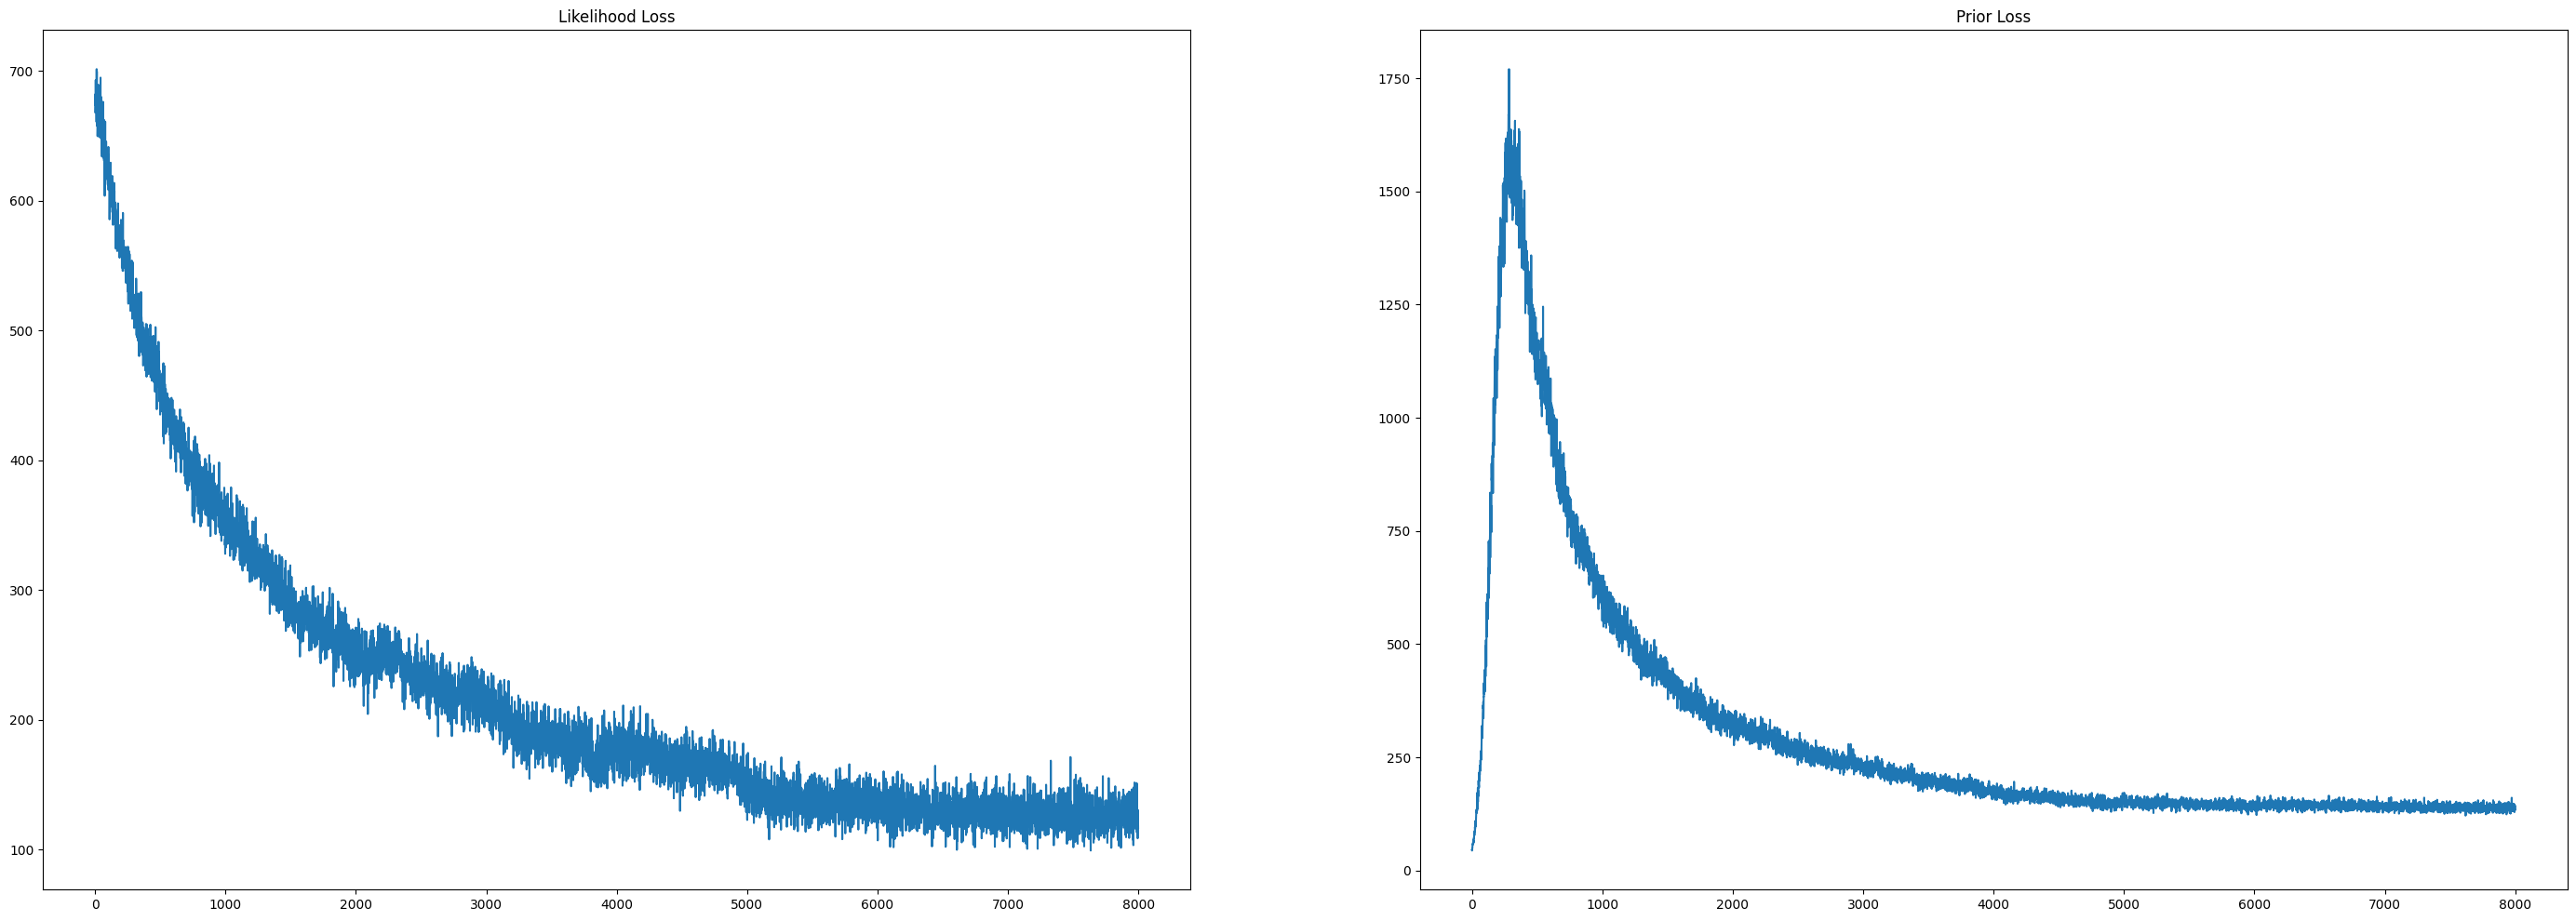

In [88]:
x_axis = np.arange(epochs)
plt.figure(figsize=(35, 12))
plt.subplot(1, 2, 1)
plt.title("Likelihood Loss")
plt.plot(x_axis, history["Likelihood Loss"])
plt.subplot(1, 2, 2)
plt.title("Prior Loss")
plt.plot(x_axis, history["Prior Loss"])

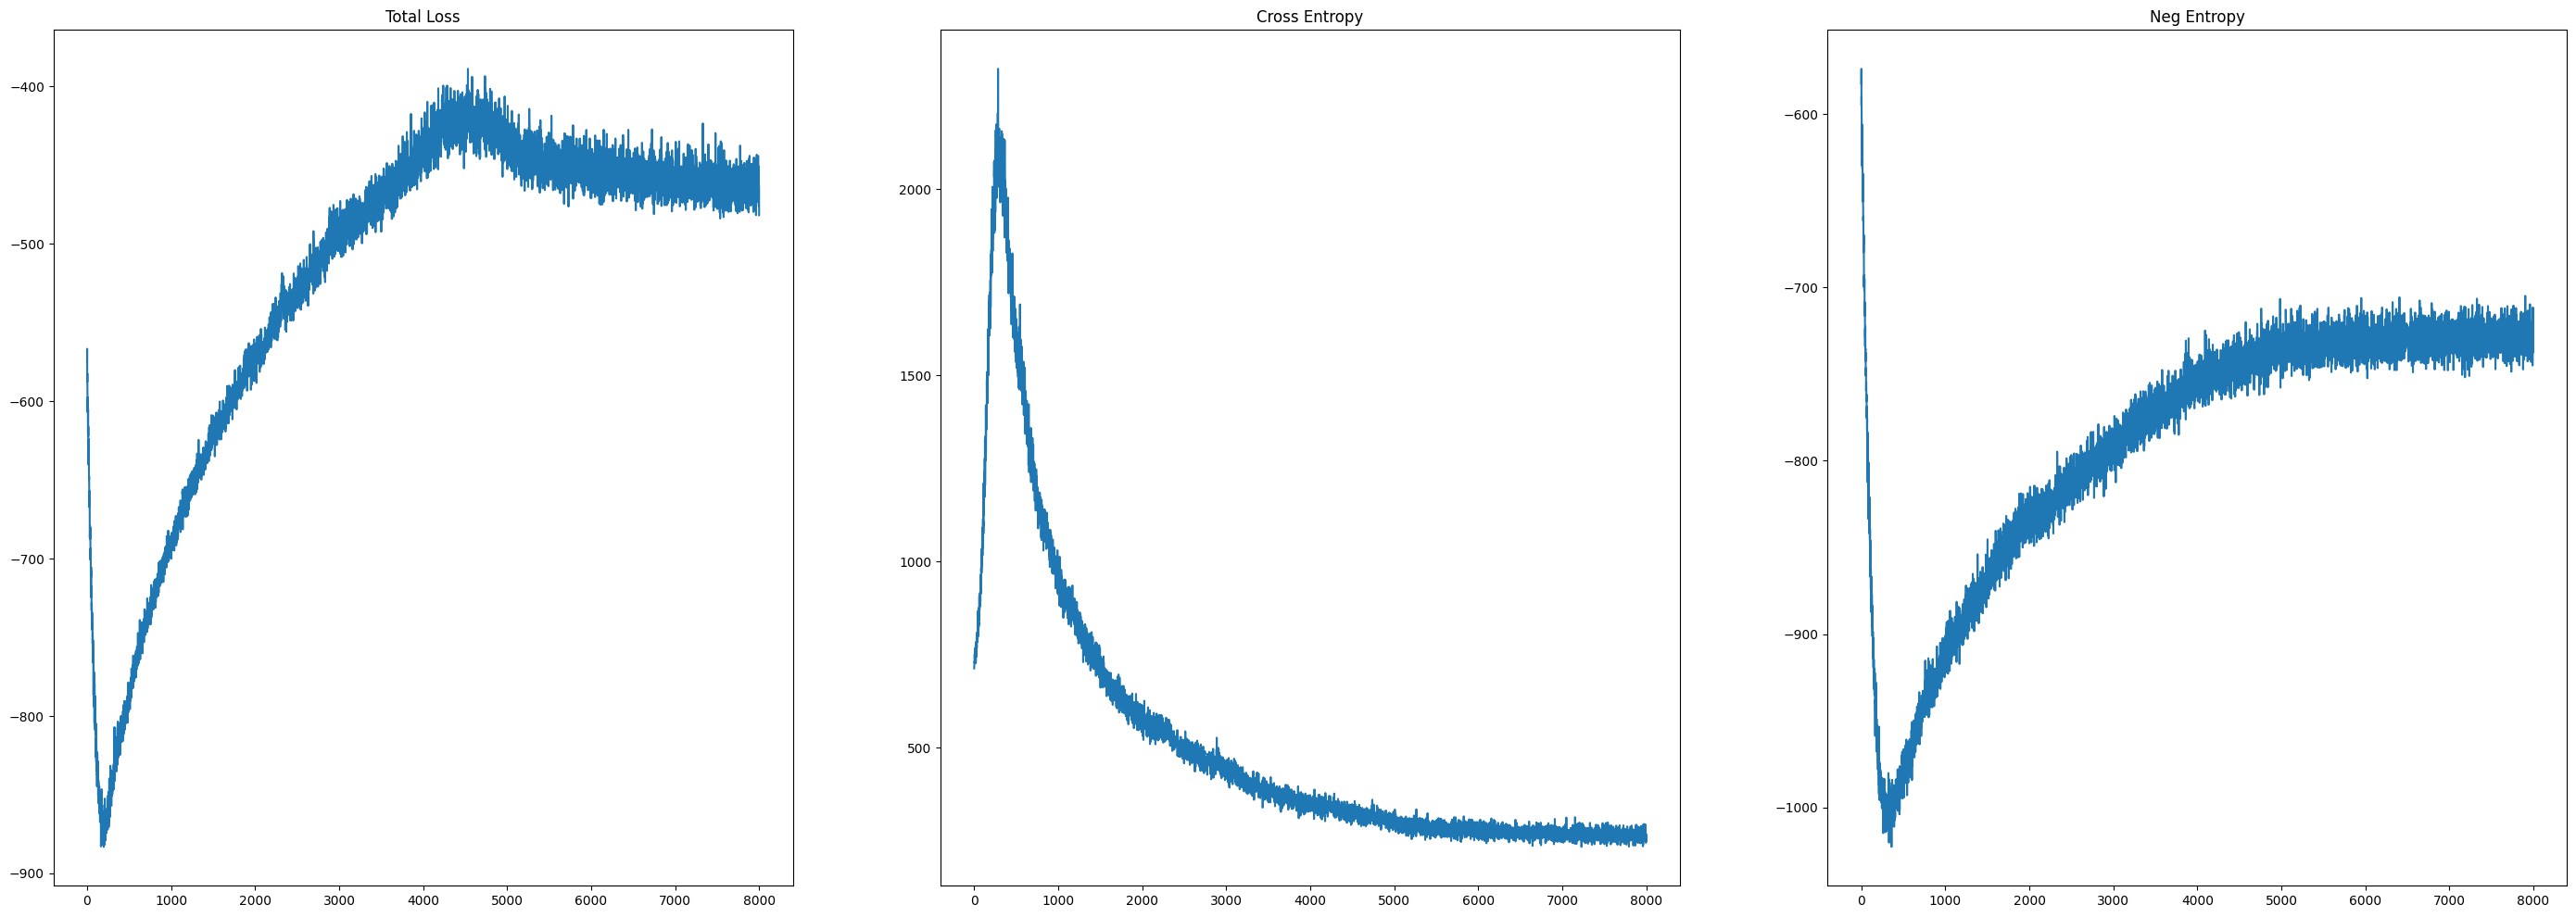

In [89]:
x_axis = np.arange(epochs)
plt.figure(figsize=(35, 12))
plt.subplot(1, 3, 1)
plt.title("Total Loss")
plt.plot(x_axis, history["Total Loss"])
plt.subplot(1, 3, 2)
plt.title("Cross Entropy")
plt.plot(x_axis, history["Cross Entropy"])
plt.subplot(1, 3, 3)
plt.title("Neg Entropy")
plt.plot(x_axis, history["Negative Entropy"])

## Results

### Percentage of correct prediction

In [156]:
# Compute the percentage of correctly predicted pixels
z_original = tf.random.normal(shape=(150, *input_shape))
z = inference_network(z_original)
generated_images = g_model(z)[-1]
correct_percentage_3d(generated_images, y, msk, print_res=True)

Percentage of successful predictions 91.23%:


91.234375

In [110]:
# Get the coordinates of observation wells
_, z_cond_pxl, x_cond_pxl, y_cond_pxl, _ = np.nonzero(msk)
wells_xy_coordinates = list(set(list(zip(x_cond_pxl, y_cond_pxl))))
wells_xy_coordinates

[(36, 40), (36, 8), (36, 104), (36, 72), (4, 40), (4, 8), (4, 104), (4, 72)]

In [111]:
wells_percentage_successes = {}

for i, coords_xy in enumerate(wells_xy_coordinates):
    x_coord, y_coord = coords_xy
    img_interpolated1 = np.argmax(generated_images, axis=-1).reshape((-1, 16, 64, 128))
    img_interpolated2 = np.argmax(x, axis=-1).reshape((-1, 16, 64, 128))
    tmp = (img_interpolated1[:, :, x_coord, y_coord] == np.squeeze(img_interpolated2[:, :, x_coord, y_coord])).astype(int)

    percentage_success = (np.mean(tmp, axis=-1) * 100)
    #wells_percentage_successes.append(np.array(percentage_success))
    wells_percentage_successes['Well {}'.format(i)] = np.array(percentage_success)

wells_percentage_successes = pd.DataFrame.from_dict(wells_percentage_successes)

<Axes: title={'center': 'Percentage of success in the each conditioning wells'}>

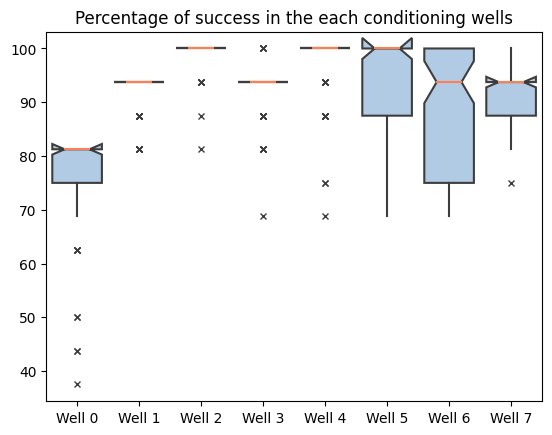

In [157]:
import seaborn as sns

# Plot the percentage of correctly predicted pixels PER WELL and show it

plt.title("Percentage of success in the each conditioning wells")
sns.boxplot(data=wells_percentage_successes, dodge=False,    notch=True, showcaps=False,
    flierprops={"marker": "x"},
    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"},)

### Visualisation of results

In [113]:
cmap, norm = get_color_map(number_of_categories=4)
z_original = tf.random.normal(shape=(5, *input_shape))
z = inference_network(z_original)
generated_images = g_model(z)[-1]
print(generated_images.shape, z_original.shape)

(5, 16, 64, 128, 4) (5, 16, 1)


(10, 16, 64, 128, 4)


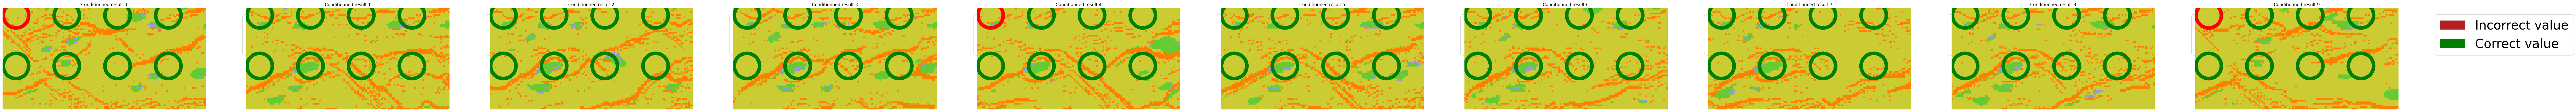

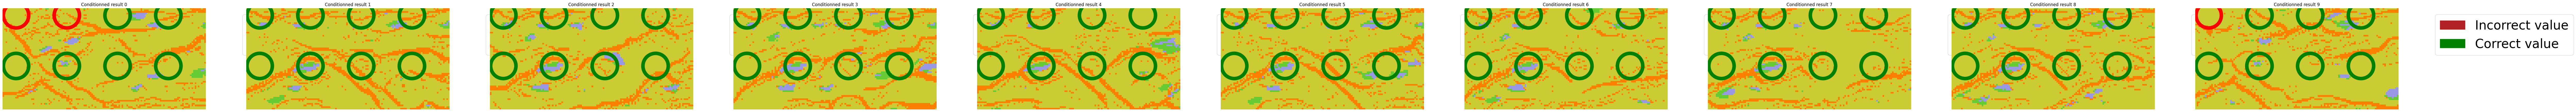

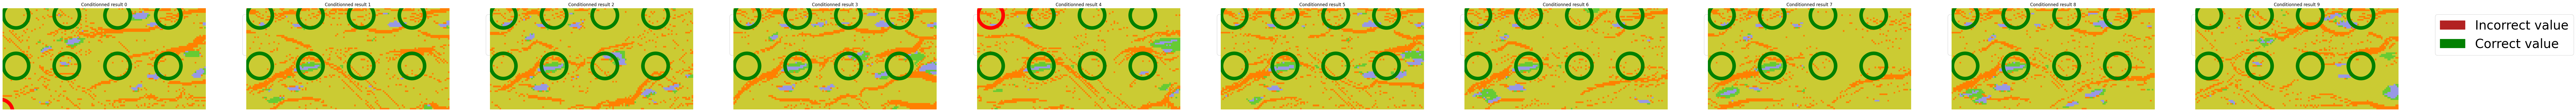

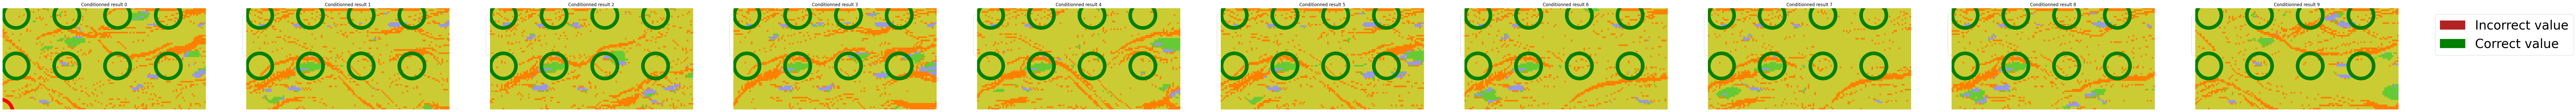

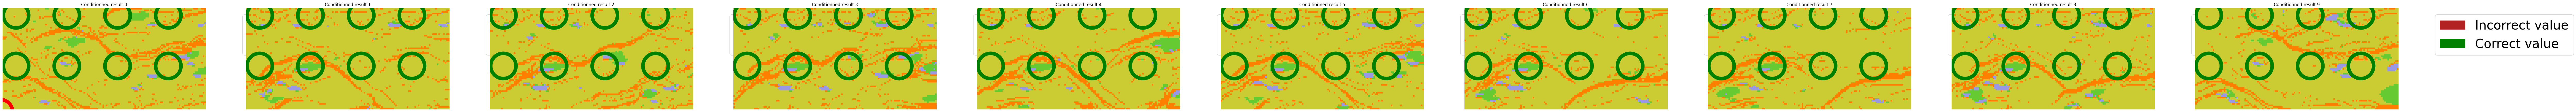

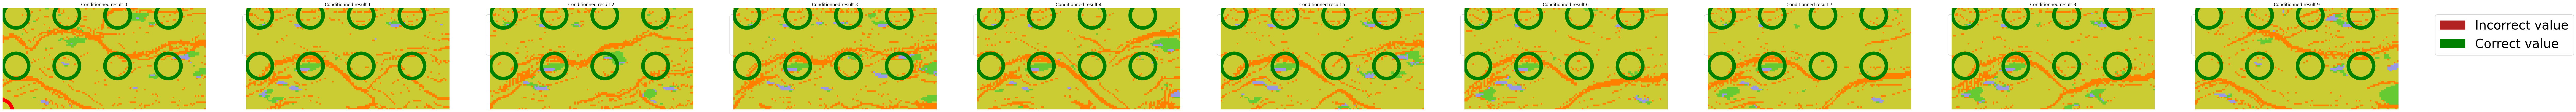

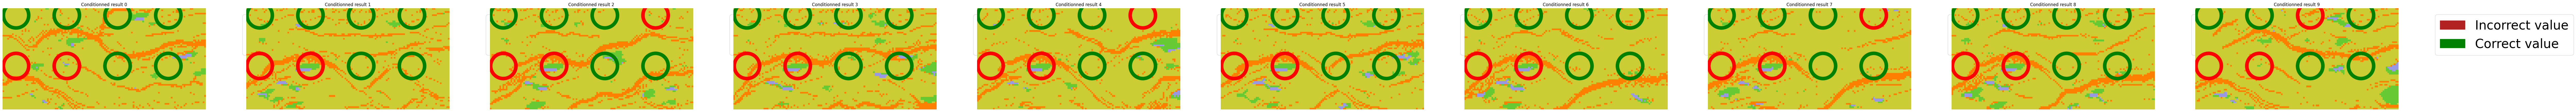

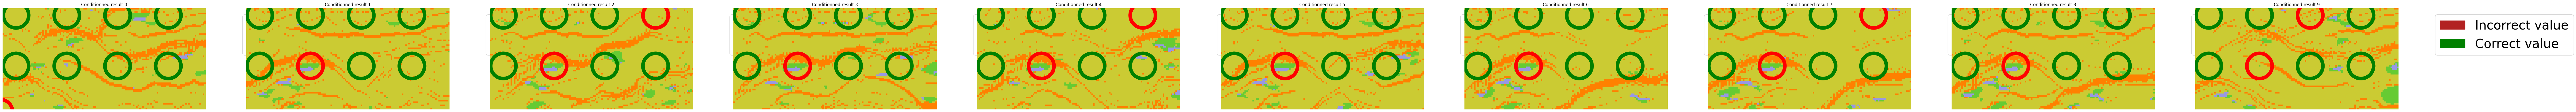

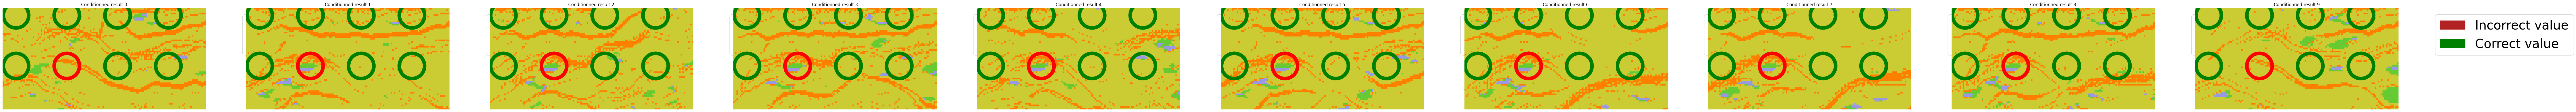

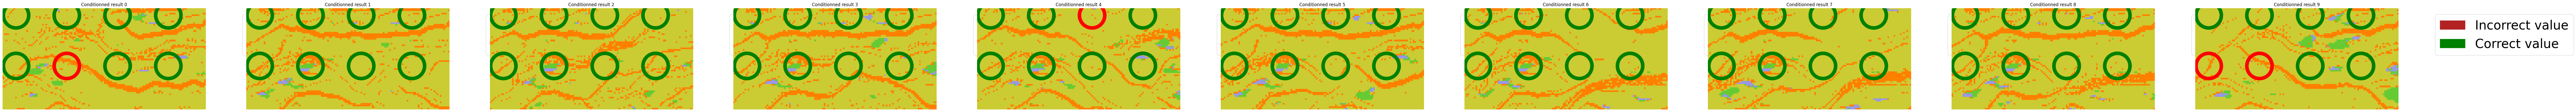

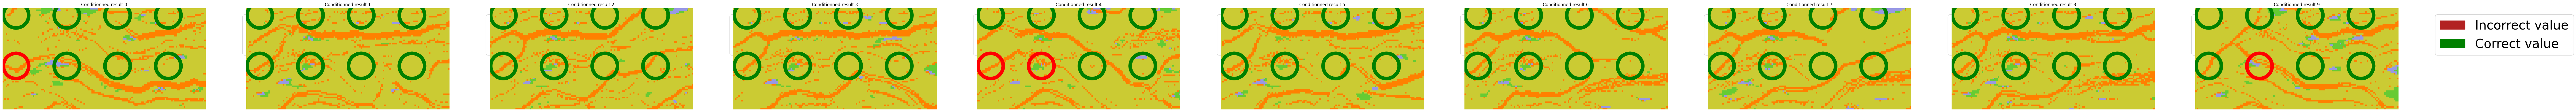

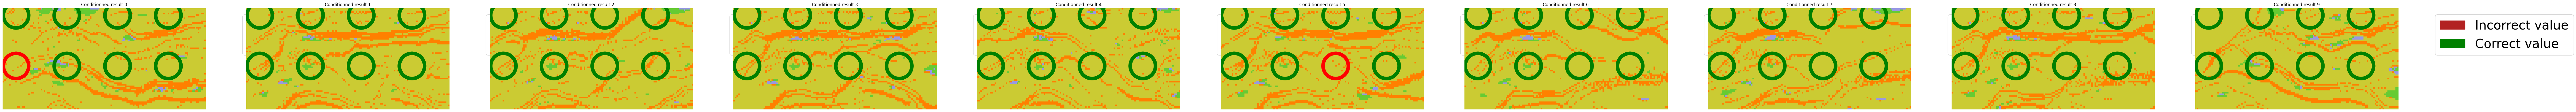

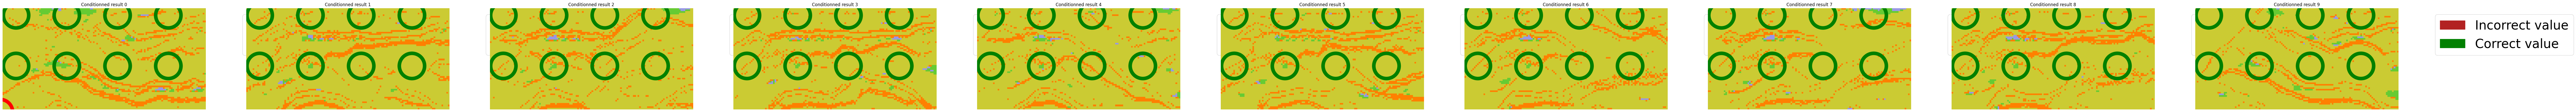

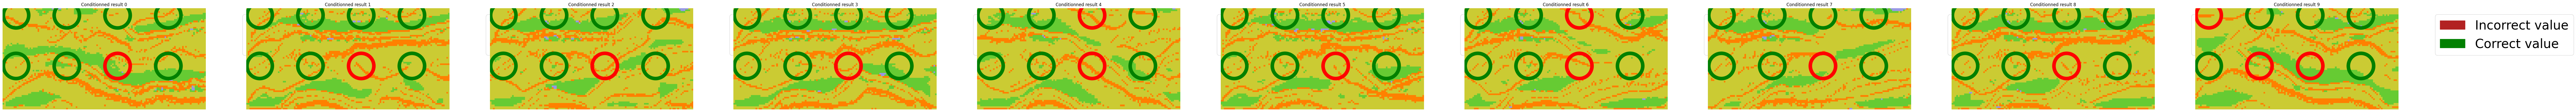

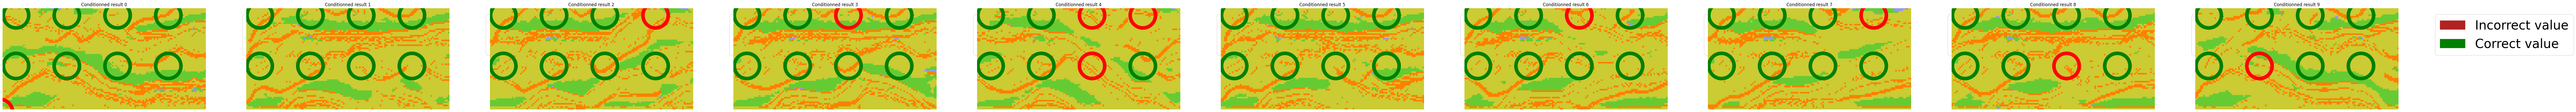

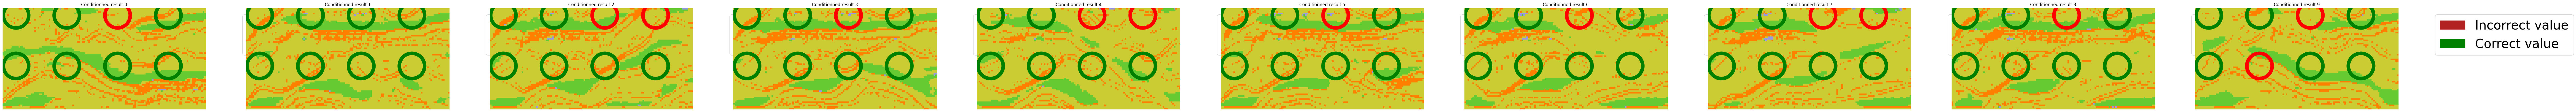

In [115]:
slice_size = (16, 64, 128, 4)
input_shape = (16, 1)

z_original = tf.random.normal(shape=(10, *input_shape))
z = inference_network(z_original)
generated_images = g_model(z)[-1]
print(generated_images.shape)

for i in range(16):
  slice_generated_images = generated_images[:, i]
  mski = np.expand_dims(msk[0, i], axis=0)
  xi = np.expand_dims(x[0, i], axis=0)
  print_conditioned_results(xi, slice_generated_images, mski, 10, cmap, norm, slice_size=(slice_size[1], slice_size[2]))
  #visualise_slice(generated_images_i, cmap, norm, 32, 64)

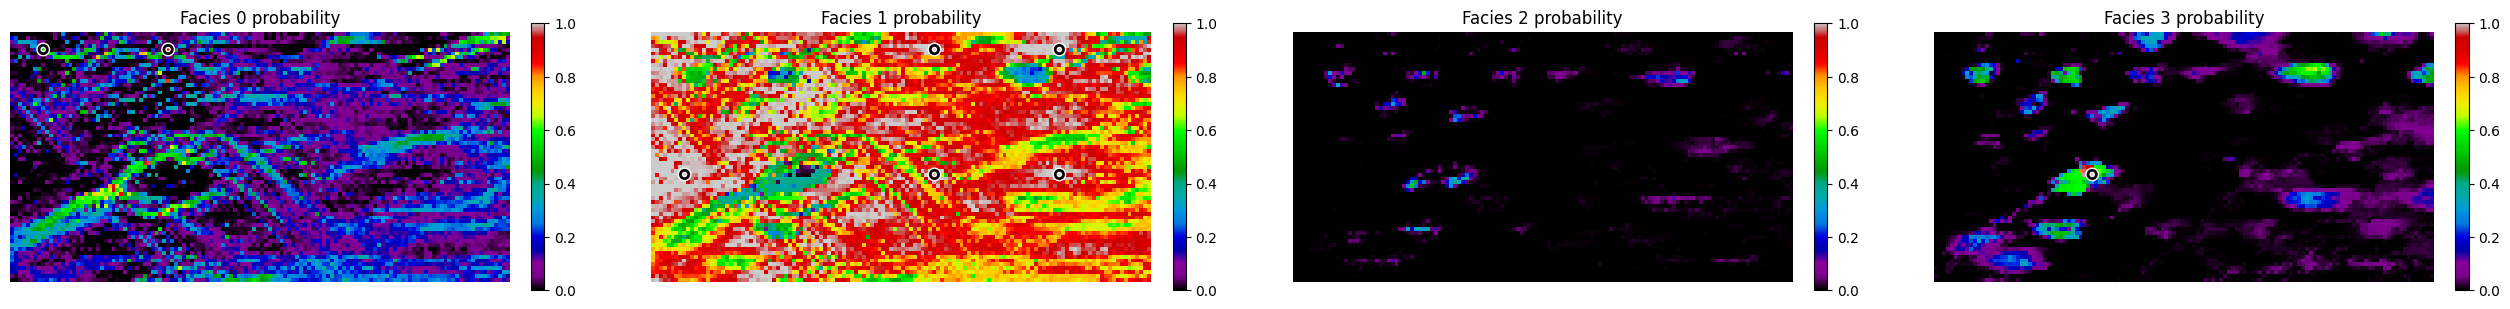

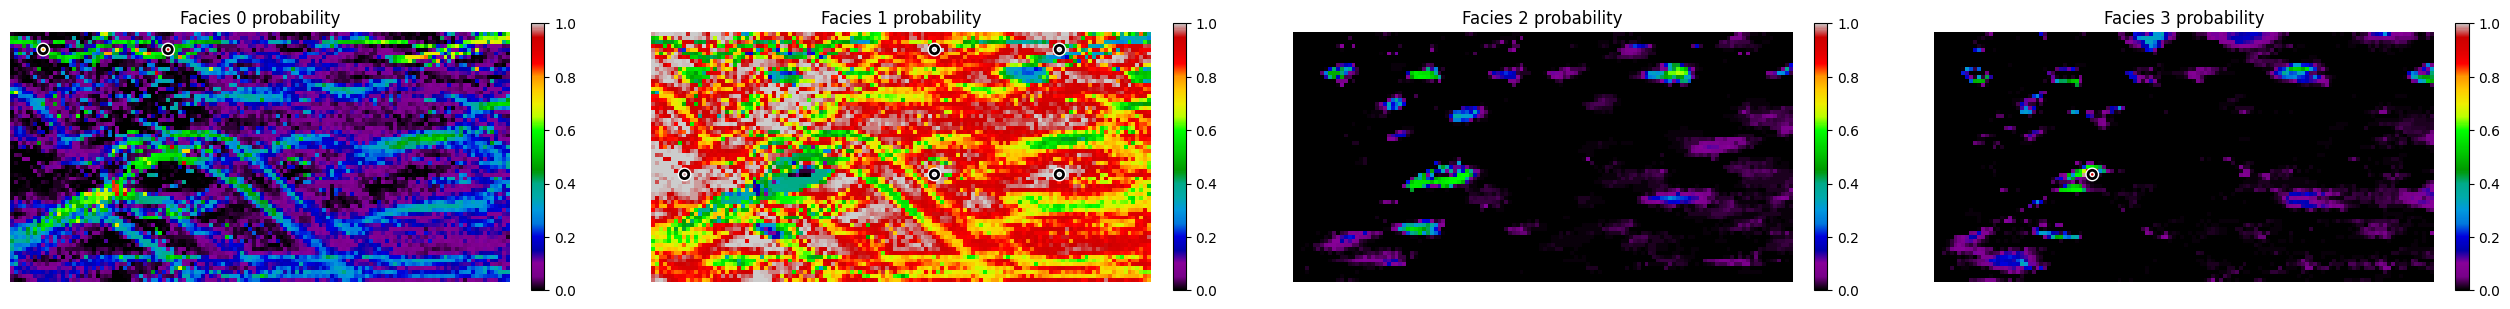

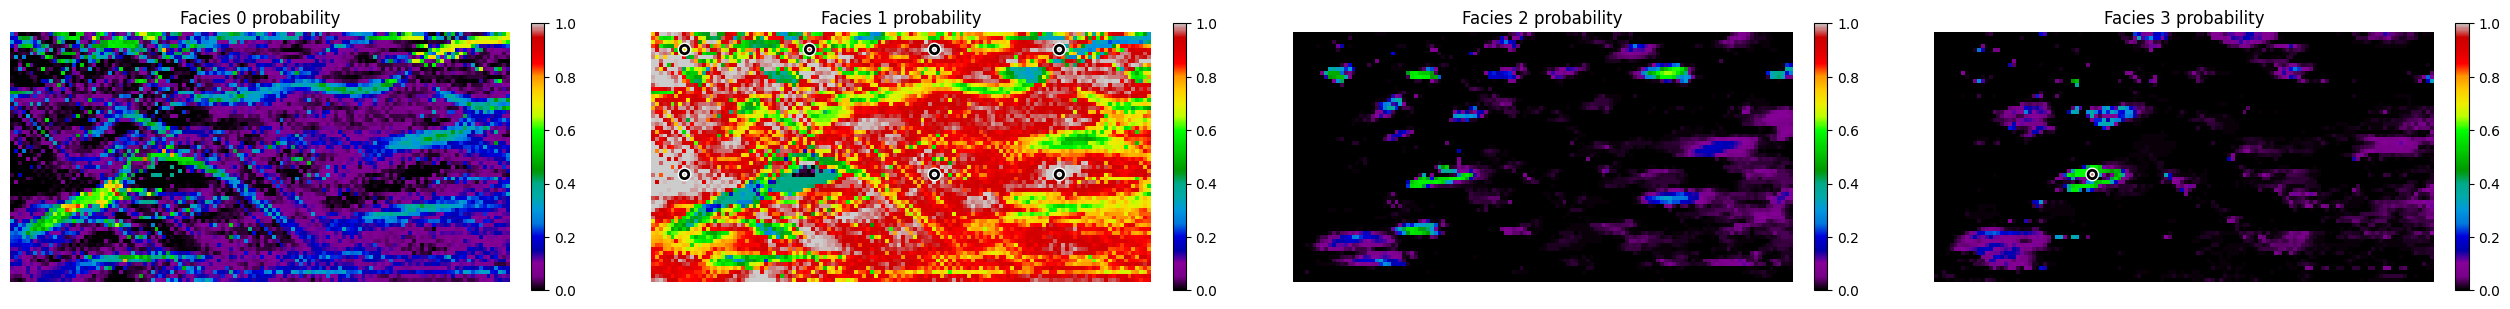

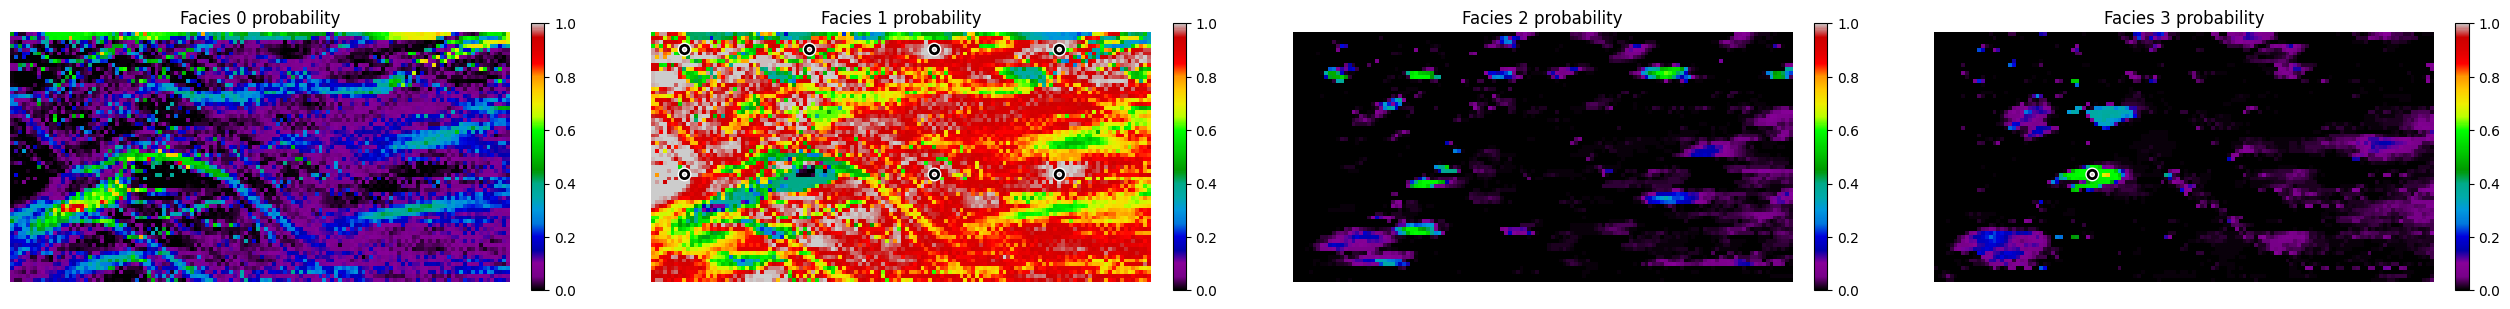

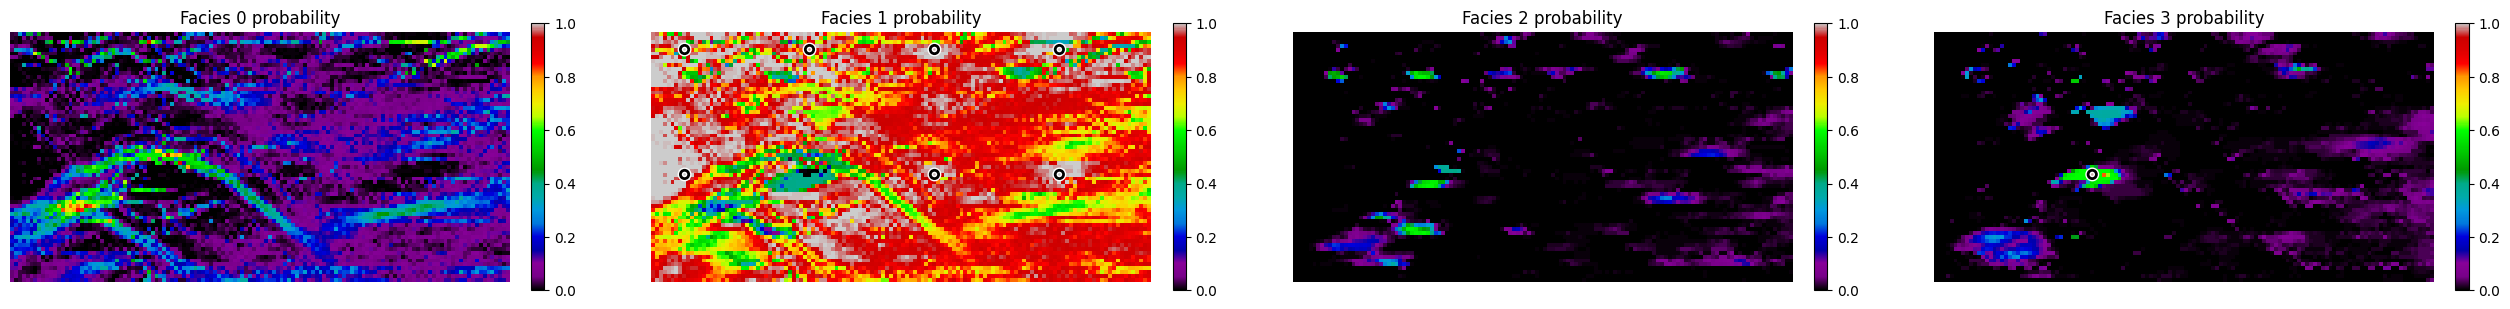

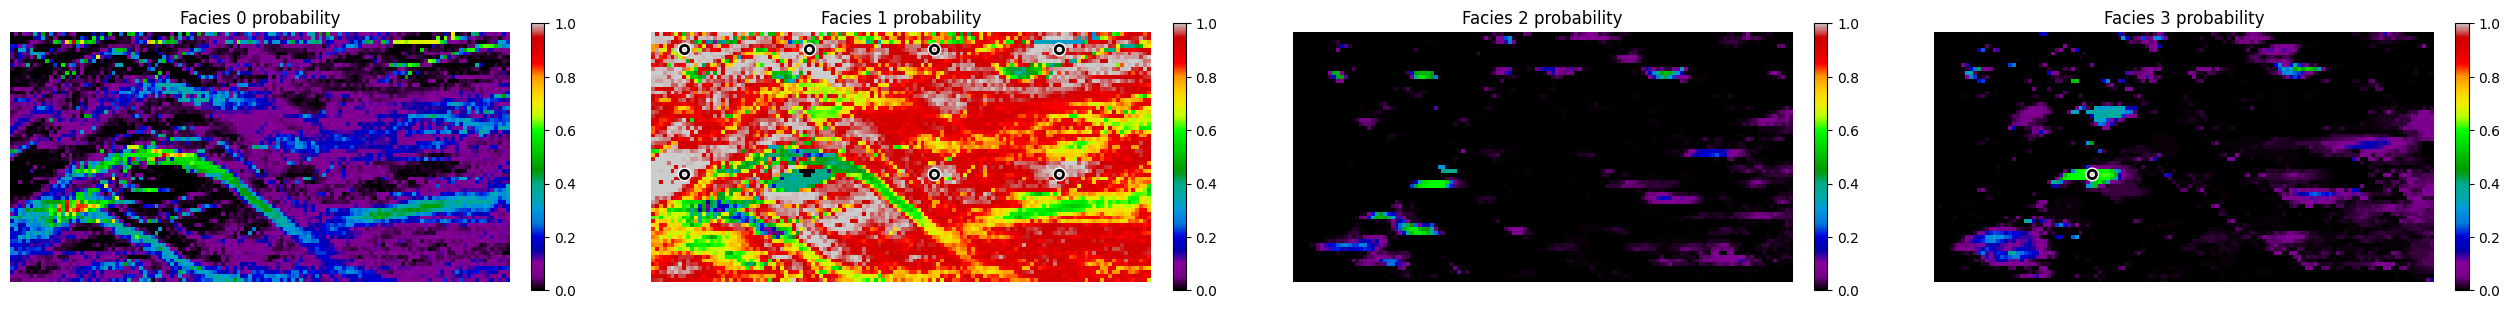

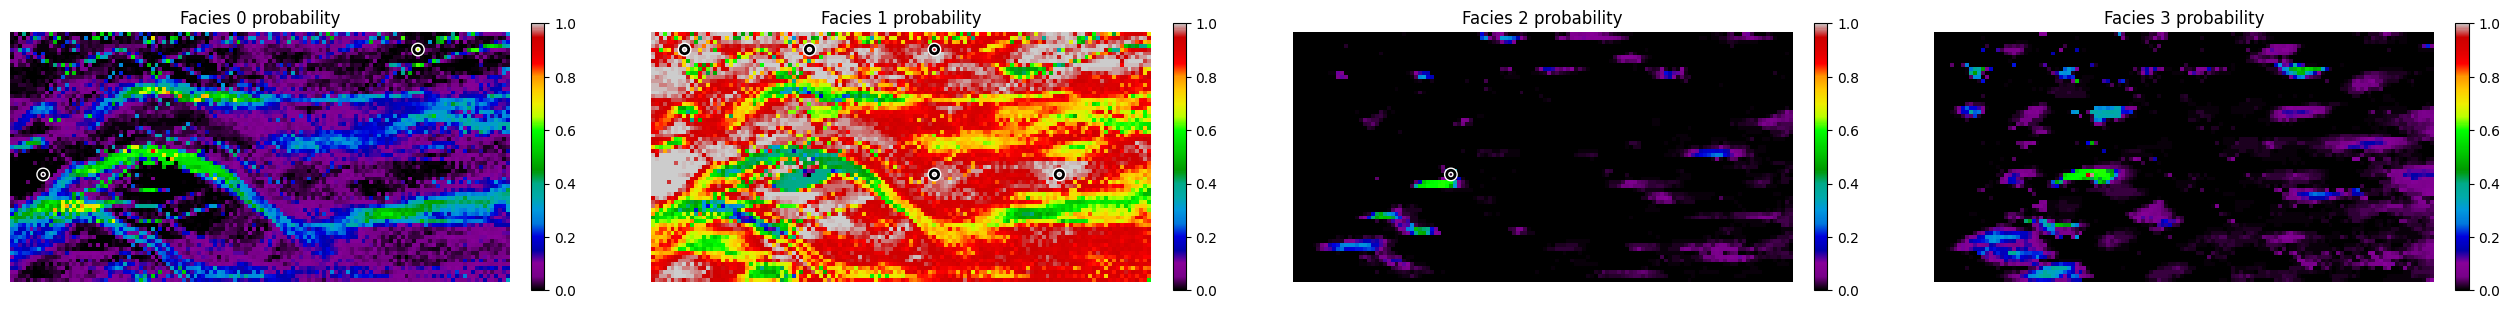

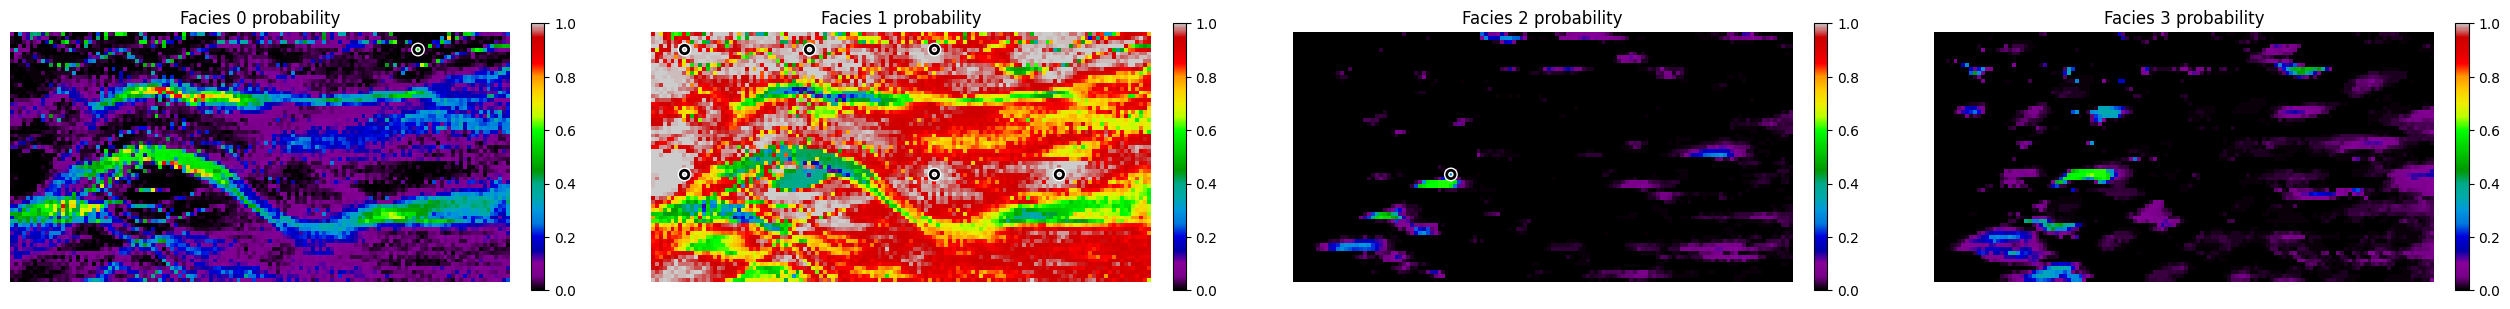

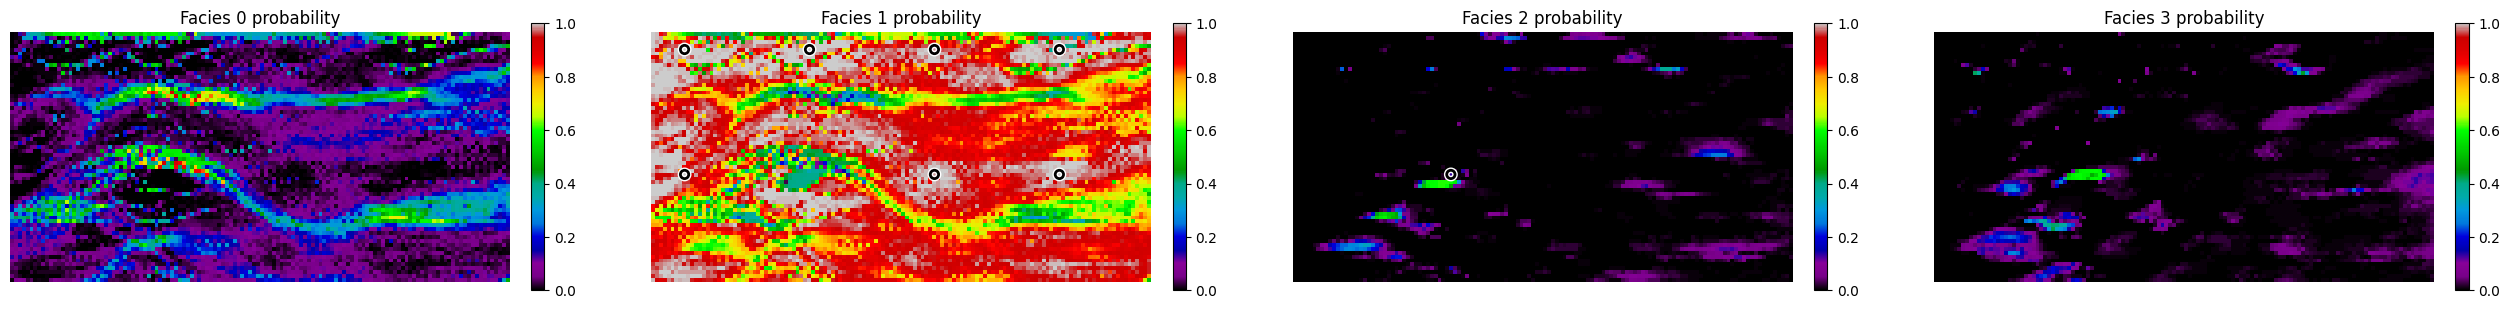

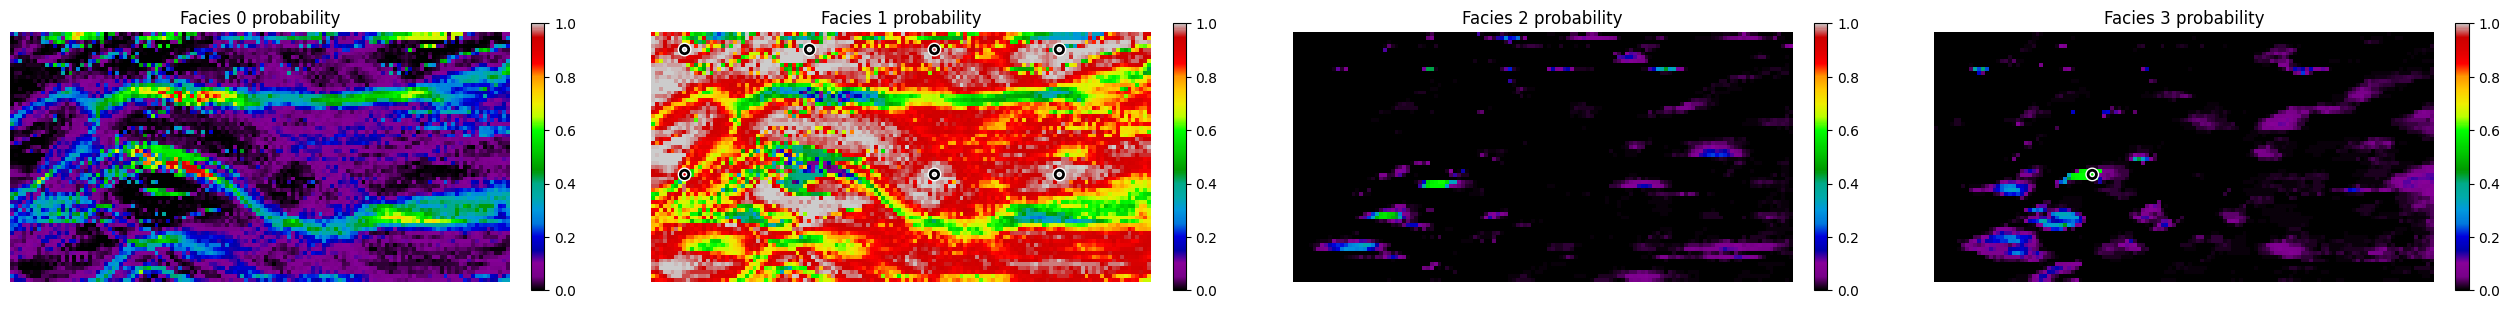

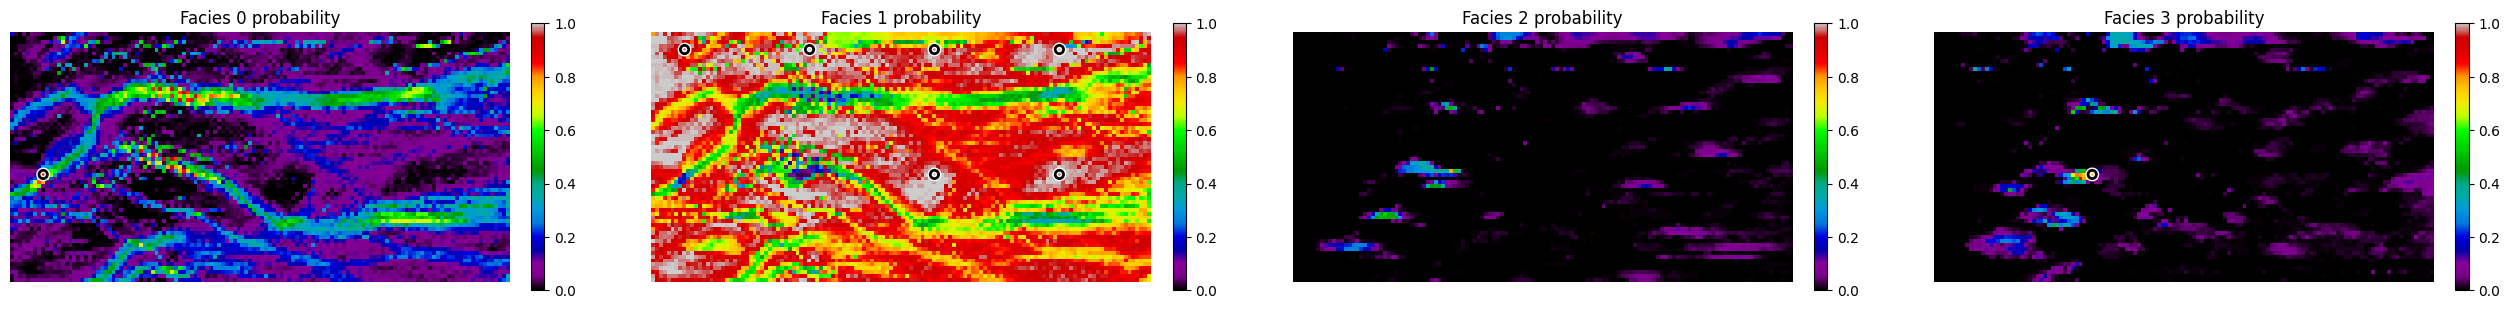

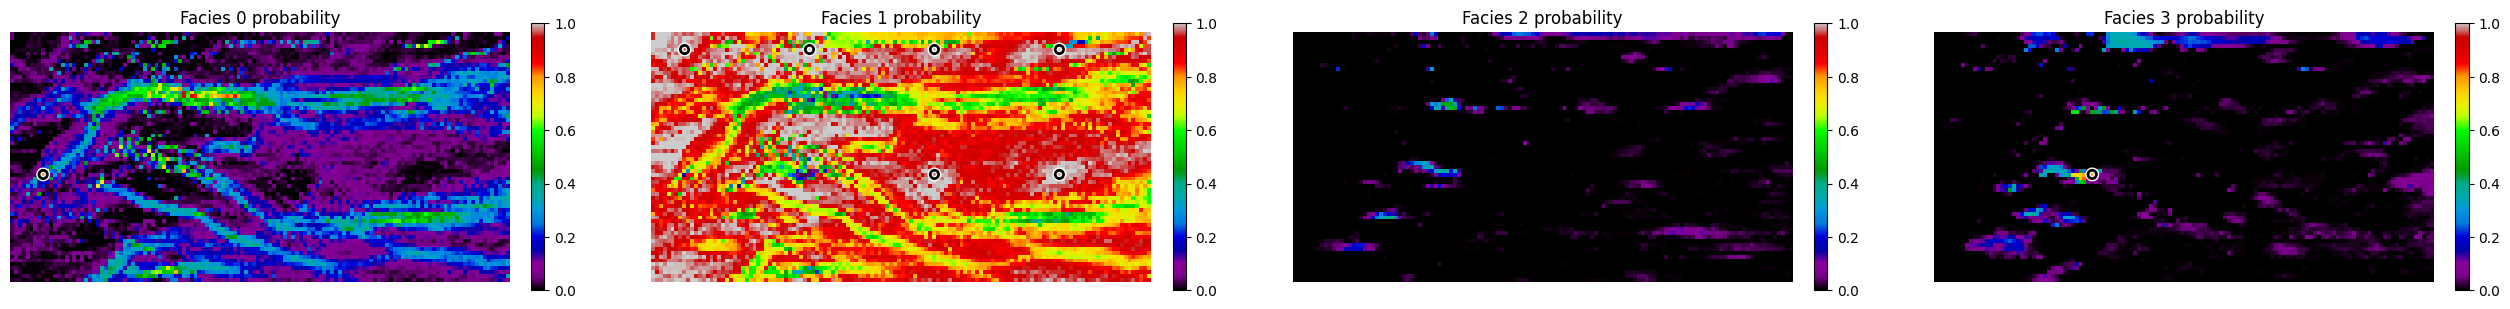

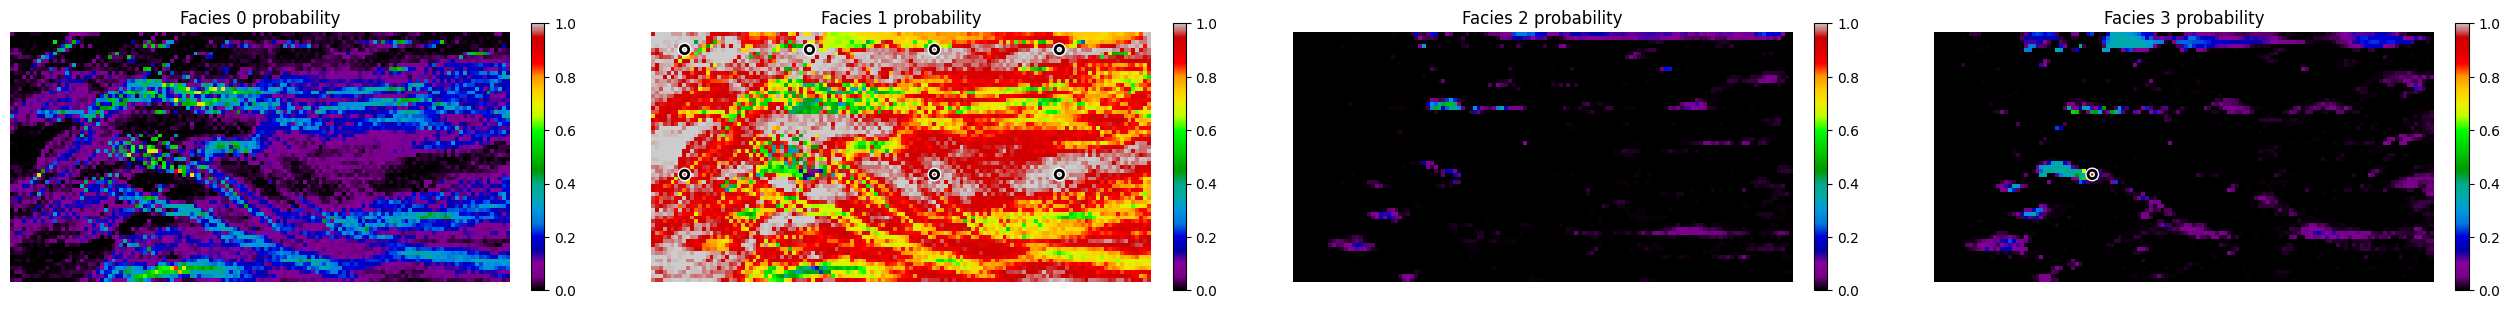

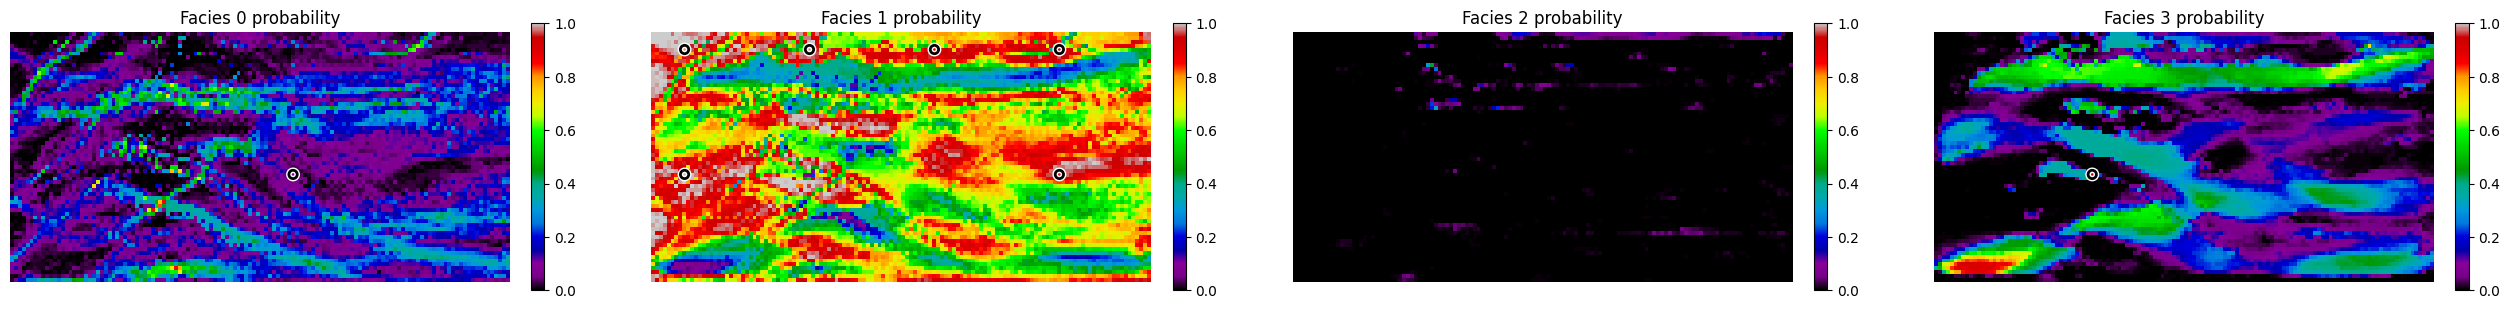

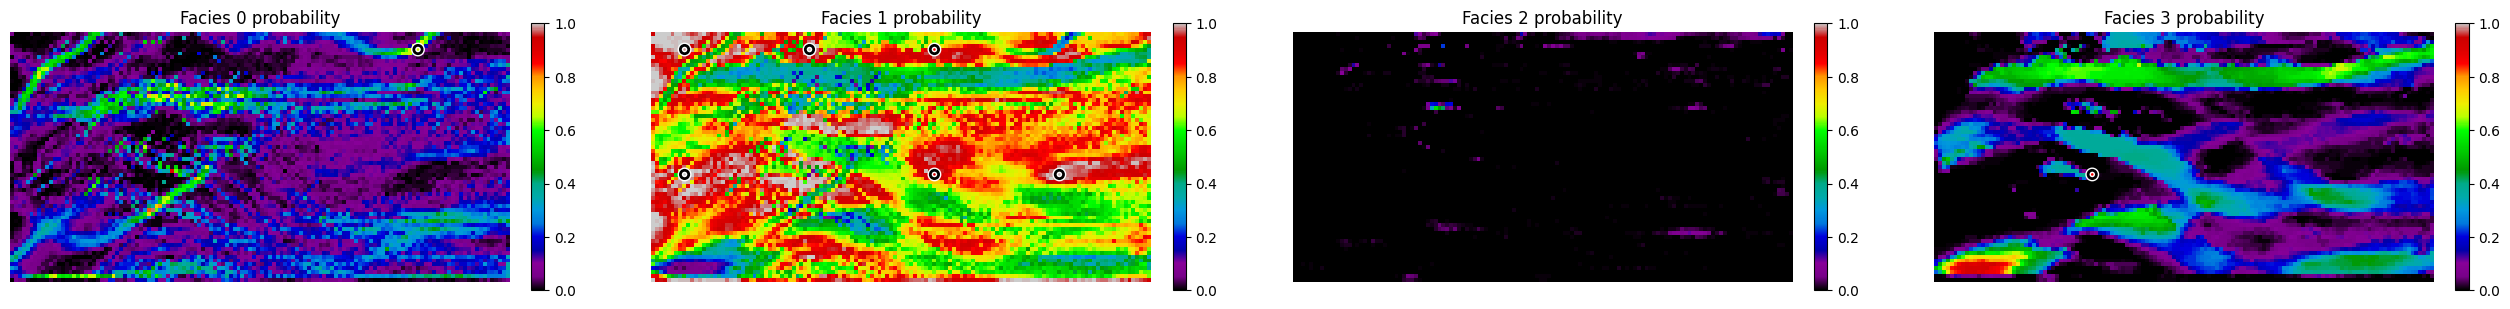

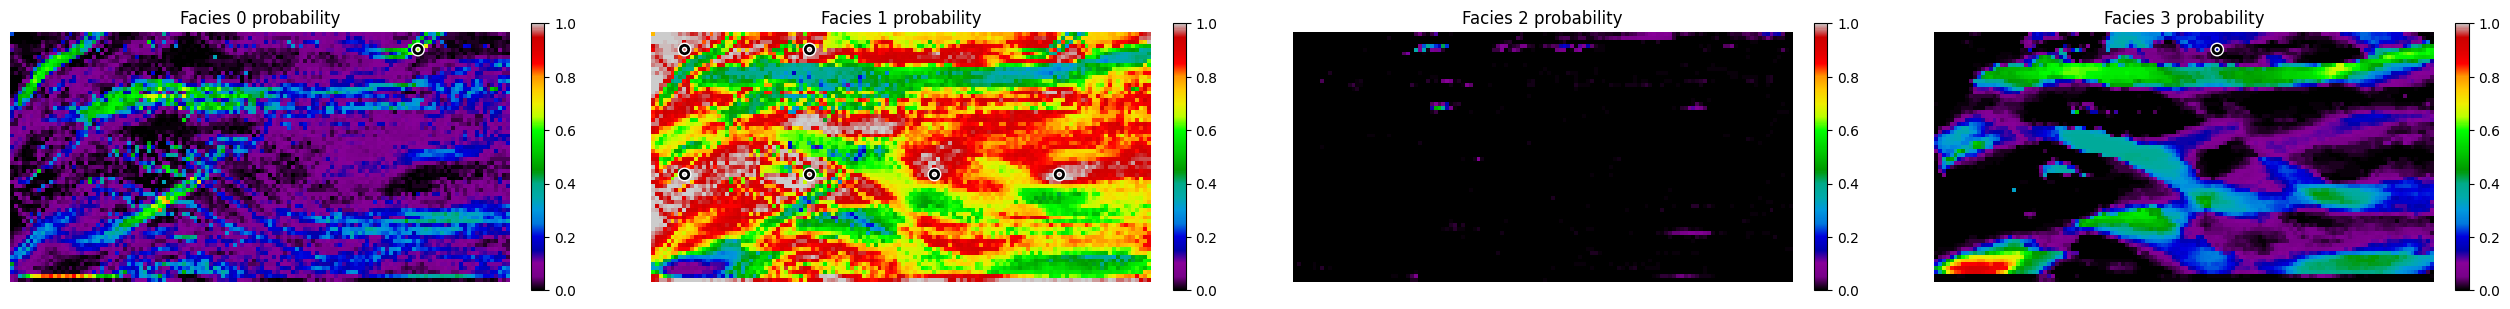

In [155]:
input_shape = (16, 1)

z_original = tf.random.normal(shape=(150, *input_shape))
z = inference_network(z_original)
generated_images = g_model(z)[-1]

for i in range(16):
  generated_images_slice = generated_images[:, i]
  proba_map, most_probable_facies = compute_probability_map(generated_images_slice)
  real_proba_map, real_most_probable_facies = compute_probability_map(y)

  mski = np.expand_dims(msk[0, i], axis=0)
  xi = np.expand_dims(x[0, i], axis=0)
  #print_conditioned_results(xi, generated_images, mski, 4, cmap, norm, slice_size=(32, 64))
  #visualise_slice(generated_images_i, cmap, norm, 32, 64)
  print_proba_map(proba_map, cmap, norm, samples=xi)

In [149]:
input_shape = (16, 1)

z_original = tf.random.normal(shape=(1, *input_shape))
z = inference_network(z_original)
generated_images = g_model(z)[-1]


In [150]:
horizontal_slice = generated_images[:, :, selected_point_x]
vertical_slice = generated_images[:, :, :, selected_point_y]

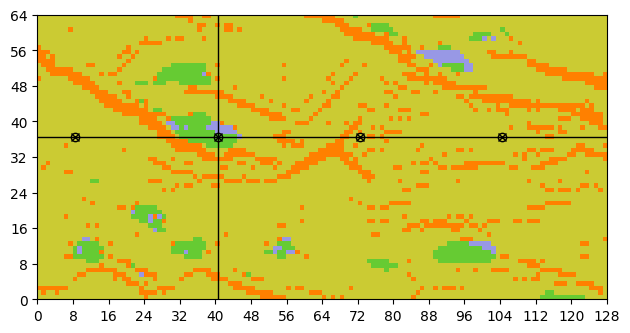

In [151]:
slice_size_wh = (64, 128)
slice_generated_images = generated_images[:, 0]
img_interpolated = np.argmax(slice_generated_images, axis=-1).reshape(slice_size_wh)
plt.axis('on')
plt.xticks(np.arange(0, 129, step=8))
plt.yticks(np.arange(0, 65, step=8))

plt.imshow(img_interpolated, interpolation='nearest', cmap=cmap, norm=norm, origin="lower", extent=(0, slice_size_wh[1], 0, slice_size_wh[0]))
#plt.plot(33.5, 19.5, marker='x', color="black")
for i in range(4):
    plt.plot(wells_xy_coordinates[i][1]+0.5, selected_point_x+0.5, marker='o', color="black", fillstyle='none')
    plt.plot(wells_xy_coordinates[i][1]+0.5, selected_point_x+0.5, marker='x', color="black", fillstyle='none')
plt.plot([0, slice_size_wh[1]], [selected_point_x + 0.5, selected_point_x + 0.5], color="black", linewidth=1)
plt.plot([selected_point_y+0.5, selected_point_y+0.5], [0, slice_size_wh[0]], color="black", linewidth=1)
plt.tight_layout()
plt.show()

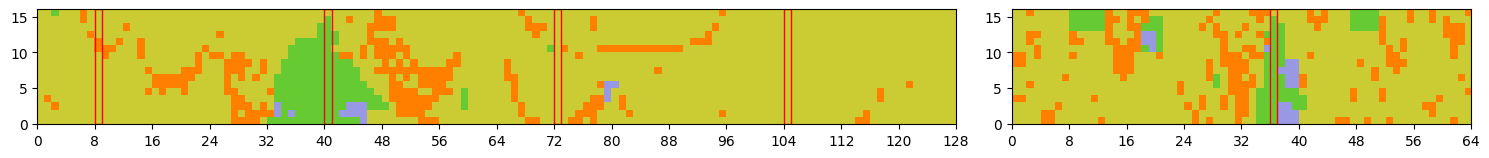

In [152]:
   # plt.figure(figsize=figsize)
from matplotlib.patches import Rectangle


depth = 16
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 2]}, figsize=(15, 15))

#plt.figsize((20, 40))

img_interpolated = np.argmax(horizontal_slice, axis=-1).reshape((depth, slice_size_wh[1]))
a0.axis('on')

a0.imshow(img_interpolated, interpolation='nearest', cmap=cmap, norm=norm, origin="lower", extent=(0, slice_size_wh[1], 0, depth))

plt.setp(a0, xticks=np.arange(0, 129, step=8))

for i in range(4):
    #plt.plot(wells_xy_coordinates[i][1]+0.5, selected_point_x+0.5, marker='o', color="black", fillstyle='none')
    #plt.plot(wells_xy_coordinates[i][1]+0.5, selected_point_x+0.5, marker='x', color="black", fillstyle='none')
    a0.add_patch(Rectangle((wells_xy_coordinates[i][1], 0),1,depth,linewidth=1,edgecolor='r',facecolor='none'))

img_interpolated = np.argmax(vertical_slice, axis=-1).reshape((depth, slice_size_wh[0]))
a1.axis('on')
a1.imshow(img_interpolated, interpolation='nearest', cmap=cmap, norm=norm, origin="lower", extent=(0, slice_size_wh[0], 0, depth))
a1.add_patch(Rectangle((selected_point_x , 0),1,depth,linewidth=1,edgecolor='r',facecolor='none'))
plt.setp(a1, xticks=np.arange(0, 65, step=8))
#a0.set_title('Vertical slice of the Flumy simulation along the y axis', fontdict={'fontsize': 10,})
#a1.set_title('Vertical slice of the Flumy simulation along the x axis', fontdict={'fontsize': 10,})
f.tight_layout()

f.show()